# ADS 509 Sentiment Assignment

This notebook holds the Sentiment Assignment for Module 6 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In a previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we apply sentiment analysis to those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
import os
import re
import emoji
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
from string import punctuation

from nltk.corpus import stopwords

sw = stopwords.words("english")

In [2]:
# Add any additional import statements you need here
import re
import seaborn as sns
import matplotlib.pyplot as plt

import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [3]:
# change `data_location` to the location of the folder on your machine.
data_location = "/Users/tarad/OneDrive/Documents/USD_GRAD_SCHOOL-C/ADS509_AppliedTextMining/Module_6/SentimentAnalysisonText_Assignment6/"

# These subfolders should still work if you correctly stored the 
# data from the Module 1 assignment
twitter_folder = os.path.join(data_location, "twitter/")
lyrics_folder = os.path.join(data_location, "lyrics/")

positive_words_file = os.path.join(data_location, "positive-words.txt")
negative_words_file = os.path.join(data_location, "negative-words.txt")
tidy_text_file = os.path.join(data_location, "tidytext_sentiments.txt")

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A Pandas data frame would work equally well. 

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist. 




In [6]:
# Read in lyrics data
def read_lyrics_data(lyrics_folder):
    lyrics_data = {}
    for artist_folder in os.listdir(lyrics_folder):
        artist_path = os.path.join(lyrics_folder, artist_folder)
        if os.path.isdir(artist_path):
            lyrics_data[artist_folder] = {}
            for file_name in os.listdir(artist_path):
                song_path = os.path.join(artist_path, file_name)
                with open(song_path, "r", encoding="utf-8") as file:
                    lyrics_data[artist_folder][file_name] = file.read()
    return lyrics_data

# Read data
lyrics_data = read_lyrics_data(lyrics_folder)

# Check first few entries
print(lyrics_data.keys())

dict_keys(['cher', 'robyn'])


In [7]:
# Read in twitter data
def read_twitter_data(twitter_folder):
    twitter_data = {}
    for file_name in os.listdir(twitter_folder):
        artist_name = os.path.splitext(file_name)[0]
        with open(os.path.join(twitter_folder, file_name), "r", encoding="utf-8", errors='replace') as file:
            twitter_data[artist_name] = file.readlines()
    return twitter_data

# Read data
twitter_data = read_twitter_data(twitter_folder)

# Check first few entries
print(twitter_data.keys())

dict_keys(['.DS_Store', 'cher_followers', 'cher_followers_data', 'robynkonichiwa_followers', 'robynkonichiwa_followers_data'])


In [8]:
# Read in the positive and negative words and the
# tidytext sentiment. Store these so that the positive
# words are associated with a score of +1 and negative words
# are associated with a score of -1. You can use a dataframe or a 
# dictionary for this.

# function to  read sentiment words from file
def read_sentiment_words(file_path):
    with open(file_path, "r", encoding='utf-8') as file:
        return [line.strip() for line in file if not line.startswith(';') and line.strip()]
    
# Reading positive and negative words
positive_words = read_sentiment_words(positive_words_file)
negative_words = read_sentiment_words(negative_words_file)


# Creating a sentiment dictionary: positive words get +1, negative words get -1
sentiment_dict = {word: 1 for word in positive_words}
sentiment_dict.update({word: -1 for word in negative_words})

# Check a few sample words
print(f"Sentiment for 'love': {sentiment_dict.get('love', 'Not Found')}")
print(f"Sentiment for 'hate': {sentiment_dict.get('hate', 'Not Found')}")

# Checking first few entries of the sentiment dictionary
print(f"Sample sentiment dictionary: {list(sentiment_dict.items())[:10]}")

Sentiment for 'love': 1
Sentiment for 'hate': -1
Sample sentiment dictionary: [('a+', 1), ('abound', 1), ('abounds', 1), ('abundance', 1), ('abundant', 1), ('accessable', 1), ('accessible', 1), ('acclaim', 1), ('acclaimed', 1), ('acclamation', 1)]


In [9]:
# Read tidy text sentiment data
tidy_text_file = os.path.join(data_location, "tidytext_sentiments.txt")

def read_tidytext_data(file_path):
    tidytext_df = pd.read_csv(file_path, delimiter='\t', header=0)
    return tidytext_df

# Read the tidytext data
tidytext_data = read_tidytext_data(tidy_text_file)

# Display the first few rows of the tidytext data to check
print(tidytext_data.head())

          word sentiment lexicon
0      abandon  negative     nrc
1    abandoned  negative     nrc
2  abandonment  negative     nrc
3         abba  positive     nrc
4    abduction  negative     nrc


## Sentiment Analysis on Songs

In this section, score the sentiment for all the songs for both artists in your data set. Score the sentiment by manually calculating the sentiment using the combined lexicons provided in this repository. 

After you have calculated these sentiments, answer the questions at the end of this section.


In [10]:
# your code here

# Clean and Tokenize text
def tokenize(text):
    # remove punctuation and split text into words
    text = re.sub(r'[^\w\s]', '', text.lower()) # remove punctuation and make lowercase
    tokens = text.split ()
    return tokens

# Print tokenized lyrics of a specific song to check it worked
def print_tokenized_lyrics_for_song(lyrics_data, artist, song):
    if artist in lyrics_data and song in lyrics_data[artist]:
        tokens = tokenize(lyrics_data[artist][song])
        print(f"Tokenized lyrics for {song} by {artist}: {tokens[:20]}") # print first 20 words only
    else:
        print(f"Song '{song}' by {artist} not found.")

# Check if worked
print_tokenized_lyrics_for_song(lyrics_data, 'cher', 'cher_88degrees.txt')

Tokenized lyrics for cher_88degrees.txt by cher: ['88', 'degrees', 'stuck', 'in', 'la', 'aint', 'got', 'no', 'friends', 'and', 'so', 'hollywood', 'nuts', 'too', 'many', 'dead', 'ends', 'life', 'on', 'the']


In [12]:
# calcultate sentiment score for a song
def calculate_sentiment_score(song_lyrics, sentiment_dict):
    tokens = tokenize(song_lyrics) # tokenize lyrics
    score = sum([sentiment_dict.get( word, 0) for word in tokens]) # sum sentiment score for each token
    return score

# Calculate sentiment scores for all songs in the dataset
def calculate_artist_sentiment(lyrics_data, sentiment_dict):
    artist_sentiment = {}
    for artist, songs in lyrics_data.items():
        artist_sentiment[artist] = {}
        for song, lyrics in songs.items():
            sentiment_score = calculate_sentiment_score(lyrics, sentiment_dict)
            artist_sentiment[artist][song] = sentiment_score
    return artist_sentiment

# Calculate the sentiment for each artist's songs
artist_sentiment =calculate_artist_sentiment(lyrics_data, sentiment_dict)

# Output the sentiment scores for both custom and tidytext sentiments
for artist, songs in artist_sentiment.items():
    print(f"\nSentiment scores for {artist}:")
    for song, sentiment_scores in songs.items():
        print(f"{song}:{sentiment_scores}")


Sentiment scores for cher:
cher_88degrees.txt:3
cher_adifferentkindoflovesong.txt:17
cher_afterall.txt:-1
cher_again.txt:1
cher_alfie.txt:7
cher_aliveagain.txt:-2
cher_allbecauseofyou.txt:3
cher_allireallywanttodo.txt:-9
cher_allornothing.txt:-8
cher_amiblue.txt:-6
cher_angelsrunning.txt:5
cher_applesdontfallfarfromthetree.txt:-3
cher_awomansstory.txt:8
cher_aworldwithoutheroes.txt:1
cher_ayounggirluneenfante.txt:3
cher_backonthestreetagain.txt:4
cher_bangbang.txt:-4
cher_bangbangmybabyshotmedown.txt:-4
cher_behindthedoor.txt:1
cher_believe.txt:28
cher_bellbottomblues.txt:-4
cher_blowininthewind.txt:-1
cher_bodytobodyhearttoheart.txt:-3
cher_bornwiththehunger.txt:-10
cher_borrowedtime.txt:18
cher_boysandgirls.txt:15
cher_buticantloveyoumore.txt:2
cher_bymyself.txt:3
cher_canyoufool.txt:-5
cher_carnival.txt:3
cher_carouselman.txt:-1
cher_catchthewind.txt:3
cher_chastityssongbandofthieves.txt:11
cher_chastitysun.txt:6
cher_chiquitita.txt:-8
cher_chiquititaspanishversion.txt:0
cher_class

### Questions

Q: Overall, which artist has the higher average sentiment per song? 

A: The artist with the higher average sentiment per song is Cher. Her average is 3.576 while Robyn's is 2.548.

In [14]:
# Calculate average sentiment for Cher
cher_sentiment_scores = list(artist_sentiment['cher'].values())
cher_average_sentiment = sum(cher_sentiment_scores) / len(cher_sentiment_scores)


# Calculate average sentiment for Robyn 
robyn_sentiment_scores = list(artist_sentiment['robyn'].values())
robyn_average_sentiment = sum(robyn_sentiment_scores) / len(robyn_sentiment_scores)

# Print Results
print(f"Cher's average sentiment: {cher_average_sentiment}")
print(f"Robyn's average sentiment: {robyn_average_sentiment}")


# Determine which artist has higher average sentiment for both custom and tidytext
if cher_sentiment_scores > robyn_sentiment_scores:
    print("Cher has the higher average custom sentiment per song.")
else:
    print("Robyn has the higher average custom sentiment per song.")

Cher's average sentiment: 3.5759493670886076
Robyn's average sentiment: 2.548076923076923
Robyn has the higher average custom sentiment per song.


### Questions

Q: For your first artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

A: The first artist is Cher and the top three songs with the highest sentiments are Perfection with 48, My Love with 45, and Love and Understanding with 44. The lowest sentiments are When you Walk Away with -17, Outrageous with -24, and I walk On Guilded Splinters with -25. For the songs with high sentiment score the key factors that drive the positive sentiment seem to be positive language with words like "love", "understanding", and "perfection". There is themes of love and empowerment as well as affirmative phrases like "my love does it good" and "love and understanding. This all leads to a overal positive tone leading to a higher sentiment. For songs with low sentiment scores, there are more negative language with words like "crazy", "misfortune" or "poison". The frequent appearance of these word slowers the sentiment score. There are also themes of loss and conflict like heartbreak and betraway, as well as dark or aggressive imagery like "I wanna see my enemies on the end of my rope". This all leads to the negative tone leading to a lower sentiment. 

In [17]:
# Get the sentiment scores for Cher's songs
cher_sentiment_sorted = sorted(artist_sentiment['cher'].items(), key=lambda x: x[1], reverse=True)

# Top 3 songs with highest sentiment
top_3_cher = cher_sentiment_sorted[:3]
print("Top 3 Cher songs by sentiment:")
for song, score in top_3_cher:
    print(f"{song}: {score}")
    print(lyrics_data['cher'][song])

# Bottom 3 songs with lowest sentiment
bottom_3_cher = cher_sentiment_sorted[-3:]
print("\nBottom 3 Cher songs by sentiment:")
for song, score in bottom_3_cher:
    print(f"{song}: {score}")
    print(lyrics_data['cher'][song])

Top 3 Cher songs by sentiment:
cher_perfection.txt: 48
"Perfection"



Hush little Baby, gotta be strong
'Cause in this world we are born to fight
Be the best, prove them wrong
A winner's work is never done, reach the top, number one

Oh, perfection
You drive me crazy with perfection
I've worn my pride as my protection
Perfection, ohh

I was taught to be tough
That the best that you can be ain't enough
Crack the whip, sacrifice
But I found out paradise had a price

I didn't know it then, but oh I know it now
You gotta work as hard as love to make the love work out
You know this heart of mine has made some big mistakes
I guess that when it comes to love, I just don't know what I takes

All my life I've been driven by perfection
Pushed it to the limit every day and night
Ohh, I've been driven by perfection
But nothing's perfect when love ain't right
Nothing's perfect when the love ain't right

Gave it all, played my part
I gave everything I had but my heart
Worked so hard, made a name
Bu

### Questions

Q: For your second artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

A: The second artist is Robyn and the top three songs with the highest sentiment are Love is Free with score 102, Indestructible with score 26, an U Should Know Better with score 26. The three songs with the lowest sentiment scores are Criminal Intent with -53,  Don't Fucking Tell me What to do with -77, and Don't Fucking Tell me What to do(alternate version) with -77. The positive sentiment in Robyn's songs comes from themes of empowerment, love, and resilience, while the negative sentiment is driven by themes of frustration, rebellion, and expressions of dissatisfaction with life.



In [19]:
# Get the sentiment scores for Robyn's songs
robyn_sentiment_sorted = sorted(artist_sentiment['robyn'].items(), key=lambda x: x[1], reverse=True)

# Top 3 songs with highest sentiment
top_3_robyn = robyn_sentiment_sorted[:3]
print("Top 3 Robyn songs by sentiment:")
for song, score in top_3_robyn:
    print(f"{song}: {score}")
    print(lyrics_data['robyn'][song])

# Bottom 3 songs with lowest sentiment
bottom_3_robyn = robyn_sentiment_sorted[-4:]
print("\nBottom 3 Robyn songs by sentiment:")
for song, score in bottom_3_robyn:
    print(f"{song}: {score}")
    print(lyrics_data['robyn'][song])

Top 3 Robyn songs by sentiment:
robyn_loveisfree.txt: 102
"Love Is Free"



Free
Love is free, baby
Free
Love is free, baby
Boom boom boom boom boom chica boom
Let me give it to you, baby
Chica boom chica boom chica boom
Chica boom chica boom chica boom
Free
Love is free, baby
Free
Love is free, baby
Boom boom boom boom boom chica boom
Let me give it to you, baby

I'ma give it to you, baby
I'ma give it when I'm ready
Some lose, some steady
Some light, some heavy
It's all over this city
Sometimes in the ugly, sometimes in the pretty
You never know where you get it cause you can't control it and you can't unfold it, slow down

I'ma give it to you, baby
I'ma give it when I'm ready
Some lose, some steady
Some light, some heavy
It's all over this city
Sometimes in the ugly, sometimes in the pretty
You never know where you get it cause you can't control it and you can't unfold it, slow down

Free
Love is free, baby
Free
Love is free, baby
Boom boom boom boom boom chica boom
Let me give it to

### Questions

Q: Plot the distributions of the sentiment scores for both artists. You can use `seaborn` to plot densities or plot histograms in matplotlib.


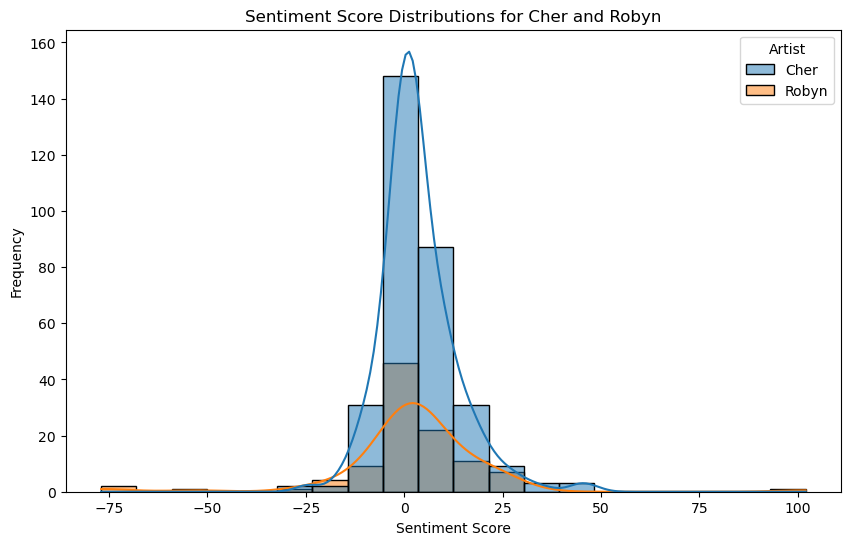

In [21]:
data = {
    'Artist': ['Cher'] * len(cher_sentiment_scores) + ['Robyn'] * len(robyn_sentiment_scores),
    'Sentiment': cher_sentiment_scores + robyn_sentiment_scores
}
df = pd.DataFrame(data)

# Plot the distribution using seaborn
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Sentiment', hue='Artist', kde=True, bins=20)
plt.title('Sentiment Score Distributions for Cher and Robyn')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

## Sentiment Analysis on Twitter Descriptions

In this section, define two sets of emojis you designate as positive and negative. Make sure to have at least 10 emojis per set. You can learn about the most popular emojis on Twitter at [the emojitracker](https://emojitracker.com/). 

Associate your positive emojis with a score of +1, negative with -1. Score the average sentiment of your two artists based on the Twitter descriptions of their followers. The average sentiment can just be the total score divided by number of followers. You do not need to calculate sentiment on non-emoji content for this section.

In [22]:
# your code here
# Define positive and negative emoji sets
positive_emojis = ['😊', '😃', '😍', '😎', '👍', '💪', '🎉', '🌟', '❤️', '👏']
negative_emojis = ['😢', '😡', '💔', '😔', '👎', '😖', '😩', '😭', '🤬', '😱']

# Create emoji sentiment dictionary
emoji_sentiment_dict = {emoji: 1 for emoji in positive_emojis}
emoji_sentiment_dict.update({emoji: -1 for emoji in negative_emojis})

# Check sentiment dictionary
print(emoji_sentiment_dict)

{'😊': 1, '😃': 1, '😍': 1, '😎': 1, '👍': 1, '💪': 1, '🎉': 1, '🌟': 1, '❤️': 1, '👏': 1, '😢': -1, '😡': -1, '💔': -1, '😔': -1, '👎': -1, '😖': -1, '😩': -1, '😭': -1, '🤬': -1, '😱': -1}


In [23]:
# Function to calculate sentiment from emoji
def calculate_emoji_sentiment(description, emoji_dict):
    score = sum([emoji_dict.get(char, 0) for char in description])
    return score

# Calculate sentiment only for 'cher_followers_data' and 'robynkonichiwa_followers_data'
def calculate_twitter_sentiment_for_selected(twitter_data, emoji_dict, selected_artists):
    twitter_sentiment = {}
    for artist in selected_artists:
        descriptions = twitter_data.get(artist, [])
        total_sentiment = 0
        num_descriptions = len(descriptions)
        for description in descriptions:
            total_sentiment += calculate_emoji_sentiment(description, emoji_dict)
        average_sentiment = total_sentiment / num_descriptions if num_descriptions > 0 else 0
        twitter_sentiment[artist] = average_sentiment
    return twitter_sentiment

# Define selected artists
selected_artists = ['cher_followers_data', 'robynkonichiwa_followers_data']

# Calculate sentiment for the selected artists' Twitter descriptions
twitter_sentiment_selected = calculate_twitter_sentiment_for_selected(twitter_data, emoji_sentiment_dict, selected_artists)

# Output average sentiment scores for each selected artist
for artist, sentiment_score in twitter_sentiment_selected.items():
    print(f"Average emoji sentiment for {artist}: {sentiment_score}")

Average emoji sentiment for cher_followers_data: 0.007644680439891419
Average emoji sentiment for robynkonichiwa_followers_data: 0.004043273349275754


Q: What is the average sentiment of your two artists? 

A: The average sentiment of the two artists are 0.00764 for Cher and 0.00404 for Robyn. Cher has the higher average in emojies which matches the song lyrics average sentiment score as well. 

---

Q: Which positive emoji is the most popular for each artist? Which negative emoji? 

A: The most popular positive emoji for Cher is 😍, and the most popular negative emoji for Cher is 💔.
The most popular positive emoji for Robyn is 😎, and the most popular negative emoji for Robyn is 💔. 
The heart break emoji being the most popular for both artists make sense. When we analyzed the lowest score songs for both artists it had to do with heartbreak themes. 



In [24]:
# Function to count emoji occurrences for each artist
def count_emoji_frequencies(descriptions, emoji_dict):
    emoji_counter = Counter()
    for description in descriptions:
        for char in description:
            if char in emoji_dict:  # Only emojis in the sentiment dictionary
                emoji_counter[char] += 1
    return emoji_counter

# Get emoji counts for Cher and Robyn followers
cher_emoji_counts = count_emoji_frequencies(twitter_data['cher_followers_data'], emoji_sentiment_dict)
robyn_emoji_counts = count_emoji_frequencies(twitter_data['robynkonichiwa_followers_data'], emoji_sentiment_dict)

# Function to find most popular positive and negative emoji
def find_most_popular_emoji(emoji_counts, emoji_dict):
    positive_emoji = max([emoji for emoji in emoji_counts if emoji_dict[emoji] == 1], key=lambda x: emoji_counts[x], default=None)
    negative_emoji = max([emoji for emoji in emoji_counts if emoji_dict[emoji] == -1], key=lambda x: emoji_counts[x], default=None)
    return positive_emoji, negative_emoji

# Find most popular positive and negative emojis for each artist
cher_positive_emoji, cher_negative_emoji = find_most_popular_emoji(cher_emoji_counts, emoji_sentiment_dict)
robyn_positive_emoji, robyn_negative_emoji = find_most_popular_emoji(robyn_emoji_counts, emoji_sentiment_dict)

# Print the results
print(f"Most popular positive emoji for Cher: {cher_positive_emoji}")
print(f"Most popular negative emoji for Cher: {cher_negative_emoji}")
print(f"Most popular positive emoji for Robyn: {robyn_positive_emoji}")
print(f"Most popular negative emoji for Robyn: {robyn_negative_emoji}")

Most popular positive emoji for Cher: 😍
Most popular negative emoji for Cher: 💔
Most popular positive emoji for Robyn: 😎
Most popular negative emoji for Robyn: 💔
